##MLOps Project
-Avanti Chandratre
-Chhaya Tundwal

In [0]:
heart_df = (spark.read
    .format("csv")
    .option("header", "true")
    .option("inferSchema", "true")
    .load("dbfs:/FileStore/heart.csv"))

In [0]:
heart_df.createOrReplaceTempView("heart_view")

Preprocessing 

In [0]:
%sql
SELECT 
    COUNT(DISTINCT Age) AS age, 
    COUNT(DISTINCT Sex) AS sex, 
    COUNT(DISTINCT ChestPainType) AS chest_pain_type, 
    COUNT(DISTINCT RestingBP) AS resting_bp, 
    COUNT(DISTINCT Cholesterol) AS cholesterol, 
    COUNT(DISTINCT FastingBS) AS fasting_bs, 
    COUNT(DISTINCT RestingECG) AS resting_ecg, 
    COUNT(DISTINCT MaxHR) AS max_hr, 
    COUNT(DISTINCT ExerciseAngina) AS exercise_angina, 
    COUNT(DISTINCT Oldpeak) AS oldpeak, 
    COUNT(DISTINCT ST_Slope) AS st_slope, 
    COUNT(DISTINCT HeartDisease) AS heart_disease
FROM heart_view;


age,sex,chest_pain_type,resting_bp,cholesterol,fasting_bs,resting_ecg,max_hr,exercise_angina,oldpeak,st_slope,heart_disease
50,2,4,67,222,2,3,119,2,53,3,2


In [0]:
%sql
SELECT * FROM heart_view LIMIT 5;


Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


In [0]:
%sql
select count(*) as num_rows from heart_view

num_rows
918


### 3. Handling missing values

In [0]:
%sql
SELECT 
    SUM(CASE WHEN Age IS NULL THEN 1 ELSE 0 END) AS missing_age,
    SUM(CASE WHEN Sex IS NULL THEN 1 ELSE 0 END) AS missing_sex,
    SUM(CASE WHEN ChestPainType IS NULL THEN 1 ELSE 0 END) AS missing_chest_pain_type,
    SUM(CASE WHEN RestingBP IS NULL THEN 1 ELSE 0 END) AS missing_resting_bp,
    SUM(CASE WHEN Cholesterol IS NULL THEN 1 ELSE 0 END) AS missing_cholesterol,
    SUM(CASE WHEN FastingBS IS NULL THEN 1 ELSE 0 END) AS missing_fasting_bs,
    SUM(CASE WHEN RestingECG IS NULL THEN 1 ELSE 0 END) AS missing_resting_ecg,
    SUM(CASE WHEN MaxHR IS NULL THEN 1 ELSE 0 END) AS missing_max_hr,
    SUM(CASE WHEN ExerciseAngina IS NULL THEN 1 ELSE 0 END) AS missing_exercise_angina,
    SUM(CASE WHEN Oldpeak IS NULL THEN 1 ELSE 0 END) AS missing_oldpeak,
    SUM(CASE WHEN ST_Slope IS NULL THEN 1 ELSE 0 END) AS missing_st_slope,
    SUM(CASE WHEN HeartDisease IS NULL THEN 1 ELSE 0 END) AS missing_heart_disease
FROM heart_view;


missing_age,missing_sex,missing_chest_pain_type,missing_resting_bp,missing_cholesterol,missing_fasting_bs,missing_resting_ecg,missing_max_hr,missing_exercise_angina,missing_oldpeak,missing_st_slope,missing_heart_disease
0,0,0,0,0,0,0,0,0,0,0,0


### Handling duplicates

In [0]:
heart_df = heart_df.dropDuplicates()


In [0]:
%sql
SELECT 
    MIN(Age) AS min_age, MAX(Age) AS max_age, AVG(Age) AS avg_age, STDDEV(Age) AS stddev_age,
    MIN(RestingBP) AS min_bp, MAX(RestingBP) AS max_bp, AVG(RestingBP) AS avg_bp, STDDEV(RestingBP) AS stddev_bp,
    MIN(Cholesterol) AS min_chol, MAX(Cholesterol) AS max_chol, AVG(Cholesterol) AS avg_chol, STDDEV(Cholesterol) AS stddev_chol,
    MIN(MaxHR) AS min_hr, MAX(MaxHR) AS max_hr, AVG(MaxHR) AS avg_hr, STDDEV(MaxHR) AS stddev_hr,
    MIN(Oldpeak) AS min_oldpeak, MAX(Oldpeak) AS max_oldpeak, AVG(Oldpeak) AS avg_oldpeak, STDDEV(Oldpeak) AS stddev_oldpeak
FROM heart_view;


min_age,max_age,avg_age,stddev_age,min_bp,max_bp,avg_bp,stddev_bp,min_chol,max_chol,avg_chol,stddev_chol,min_hr,max_hr,avg_hr,stddev_hr,min_oldpeak,max_oldpeak,avg_oldpeak,stddev_oldpeak
28,77,53.510893246187365,9.43261650673202,0,200,132.39651416122004,18.514154119907808,0,603,198.7995642701525,109.38414455220345,60,202,136.80936819172112,25.46033413825029,-2.6,6.2,0.8873638344226581,1.0665701510493264


Standardizing Categorical Data (Converting Text to Consistent Format)

### 4. Categorical Encoding

In [0]:
from pyspark.ml.feature import StringIndexer, OneHotEncoder
from pyspark.ml import Pipeline

# Define categorical columns
categorical_columns = ["Sex", "ChestPainType", "RestingECG", "ExerciseAngina", "ST_Slope"]

# StringIndexer for categorical columns
indexers = [StringIndexer(inputCol=col, outputCol=col+"_index", handleInvalid="keep") for col in categorical_columns]

# OneHotEncoder for indexed columns
encoders = [OneHotEncoder(inputCol=col+"_index", outputCol=col+"_encoded") for col in categorical_columns]

# Create a pipeline for transformation
pipeline = Pipeline(stages=indexers + encoders)

# Fit and transform the DataFrame
transformed_df = pipeline.fit(heart_df).transform(heart_df)

# Select only the encoded columns
encoded_columns = [col+"_encoded" for col in categorical_columns]
encoded_df = transformed_df.select(encoded_columns)

# Select only the original numeric columns (excluding categorical ones)
numeric_columns = [col for col in heart_df.columns if col not in categorical_columns]
numeric_df = transformed_df.select(numeric_columns)

# The final DataFrame without original categorical columns, but with encoded ones
heart_df_enc = numeric_df.join(encoded_df, how="inner")

# Show the final transformed DataFrame
heart_df_enc.show(5)


+---+---------+-----------+---------+-----+-------+------------+-------------+---------------------+------------------+----------------------+----------------+
|Age|RestingBP|Cholesterol|FastingBS|MaxHR|Oldpeak|HeartDisease|  Sex_encoded|ChestPainType_encoded|RestingECG_encoded|ExerciseAngina_encoded|ST_Slope_encoded|
+---+---------+-----------+---------+-----+-------+------------+-------------+---------------------+------------------+----------------------+----------------+
| 37|      130|        283|        0|   98|    0.0|           0|(2,[0],[1.0])|        (4,[0],[1.0])|     (3,[1],[1.0])|         (2,[1],[1.0])|   (3,[0],[1.0])|
| 48|      138|        214|        0|  108|    1.5|           1|(2,[0],[1.0])|        (4,[0],[1.0])|     (3,[1],[1.0])|         (2,[1],[1.0])|   (3,[0],[1.0])|
| 49|      160|        180|        0|  156|    1.0|           1|(2,[0],[1.0])|        (4,[0],[1.0])|     (3,[1],[1.0])|         (2,[1],[1.0])|   (3,[0],[1.0])|
| 54|      150|        195|        0|  1

In [0]:
heart_df.show(5,truncate=False)

+---+---+-------------+---------+-----------+---------+----------+-----+--------------+-------+--------+------------+
|Age|Sex|ChestPainType|RestingBP|Cholesterol|FastingBS|RestingECG|MaxHR|ExerciseAngina|Oldpeak|ST_Slope|HeartDisease|
+---+---+-------------+---------+-----------+---------+----------+-----+--------------+-------+--------+------------+
|37 |M  |ATA          |130      |283        |0        |ST        |98   |N             |0.0    |Up      |0           |
|48 |F  |ASY          |138      |214        |0        |Normal    |108  |Y             |1.5    |Flat    |1           |
|49 |F  |NAP          |160      |180        |0        |Normal    |156  |N             |1.0    |Flat    |1           |
|54 |M  |NAP          |150      |195        |0        |Normal    |122  |N             |0.0    |Up      |0           |
|40 |M  |ATA          |140      |289        |0        |Normal    |172  |N             |0.0    |Up      |0           |
+---+---+-------------+---------+-----------+---------+-

###5. Optimize Data Storage using Parquet Format

In [0]:
heart_df_enc.write.mode("overwrite").parquet("dbfs:/mnt/heart_data/heart_cleaned.parquet")


### 6. Generate Summary Statistics using Spark SQL

In [0]:
heart_df_enc = spark.read.parquet("dbfs:/mnt/heart_data/heart_cleaned.parquet")


In [0]:
# Selecting only numerical columns
numerical_columns = ["Age", "RestingBP", "Cholesterol", "FastingBS", "MaxHR", "Oldpeak"]
numerical_df = heart_df_enc.select(numerical_columns)

# Generate summary statistics
numerical_df.describe().show()


+-------+------------------+------------------+-----------------+-------------------+------------------+------------------+
|summary|               Age|         RestingBP|      Cholesterol|          FastingBS|             MaxHR|           Oldpeak|
+-------+------------------+------------------+-----------------+-------------------+------------------+------------------+
|  count|            842724|            842724|           842724|             842724|            842724|            842724|
|   mean|53.510893246187365|132.39651416122004|198.7995642701525|0.23311546840958605|136.80936819172112|0.8873638344223519|
| stddev| 9.427483109613252| 18.50407838902818|109.3246157616465| 0.4228153958108307|25.446478173067167|1.0659897046656144|
|    min|                28|                 0|                0|                  0|                60|              -2.6|
|    max|                77|               200|              603|                  1|               202|               6.2|
+-------

### 7. Visualize Trends, Distributions, and Correlations using Matplotlib/Seaborn

In [0]:
heart_pd = heart_df_enc.toPandas()
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


In [0]:
heart_pd.head()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease,Sex_encoded,ChestPainType_encoded,RestingECG_encoded,ExerciseAngina_encoded,ST_Slope_encoded
0,58,128,216,0,131,2.2,1,"(1.0, 0.0)","(1.0, 0.0, 0.0, 0.0)","(0.0, 1.0, 0.0)","(0.0, 1.0)","(1.0, 0.0, 0.0)"
1,41,130,172,0,130,2.0,1,"(1.0, 0.0)","(1.0, 0.0, 0.0, 0.0)","(0.0, 1.0, 0.0)","(0.0, 1.0)","(1.0, 0.0, 0.0)"
2,59,130,318,0,120,1.0,0,"(1.0, 0.0)","(1.0, 0.0, 0.0, 0.0)","(0.0, 1.0, 0.0)","(0.0, 1.0)","(1.0, 0.0, 0.0)"
3,44,135,491,0,135,0.0,1,"(1.0, 0.0)","(1.0, 0.0, 0.0, 0.0)","(0.0, 1.0, 0.0)","(0.0, 1.0)","(1.0, 0.0, 0.0)"
4,51,150,200,0,120,0.5,0,"(1.0, 0.0)","(1.0, 0.0, 0.0, 0.0)","(0.0, 1.0, 0.0)","(0.0, 1.0)","(1.0, 0.0, 0.0)"


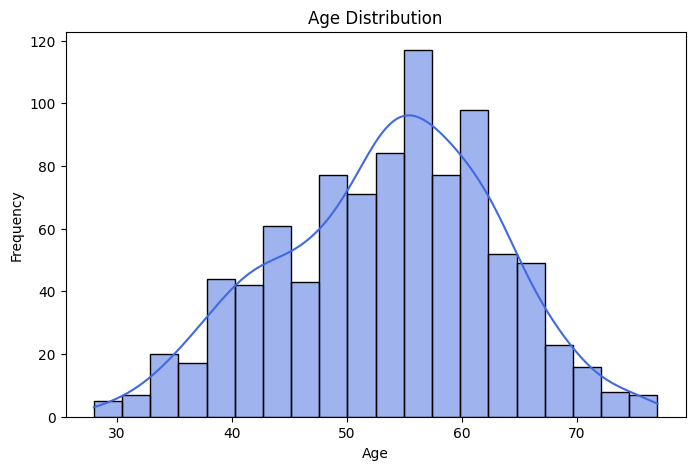

In [0]:
import matplotlib.pyplot as plt
import seaborn as sns
 
# Convert the PySpark DataFrame to a Pandas DataFrame
heart_df_pd = heart_df.toPandas()
 
# Plot the histogram
plt.figure(figsize=(8, 5))
sns.histplot(heart_df_pd['Age'], bins=20, kde=True, color='royalblue')
 
# Labels and title
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.title('Age Distribution')
 
# Show plot
plt.show()


<Figure size 1000x800 with 0 Axes>

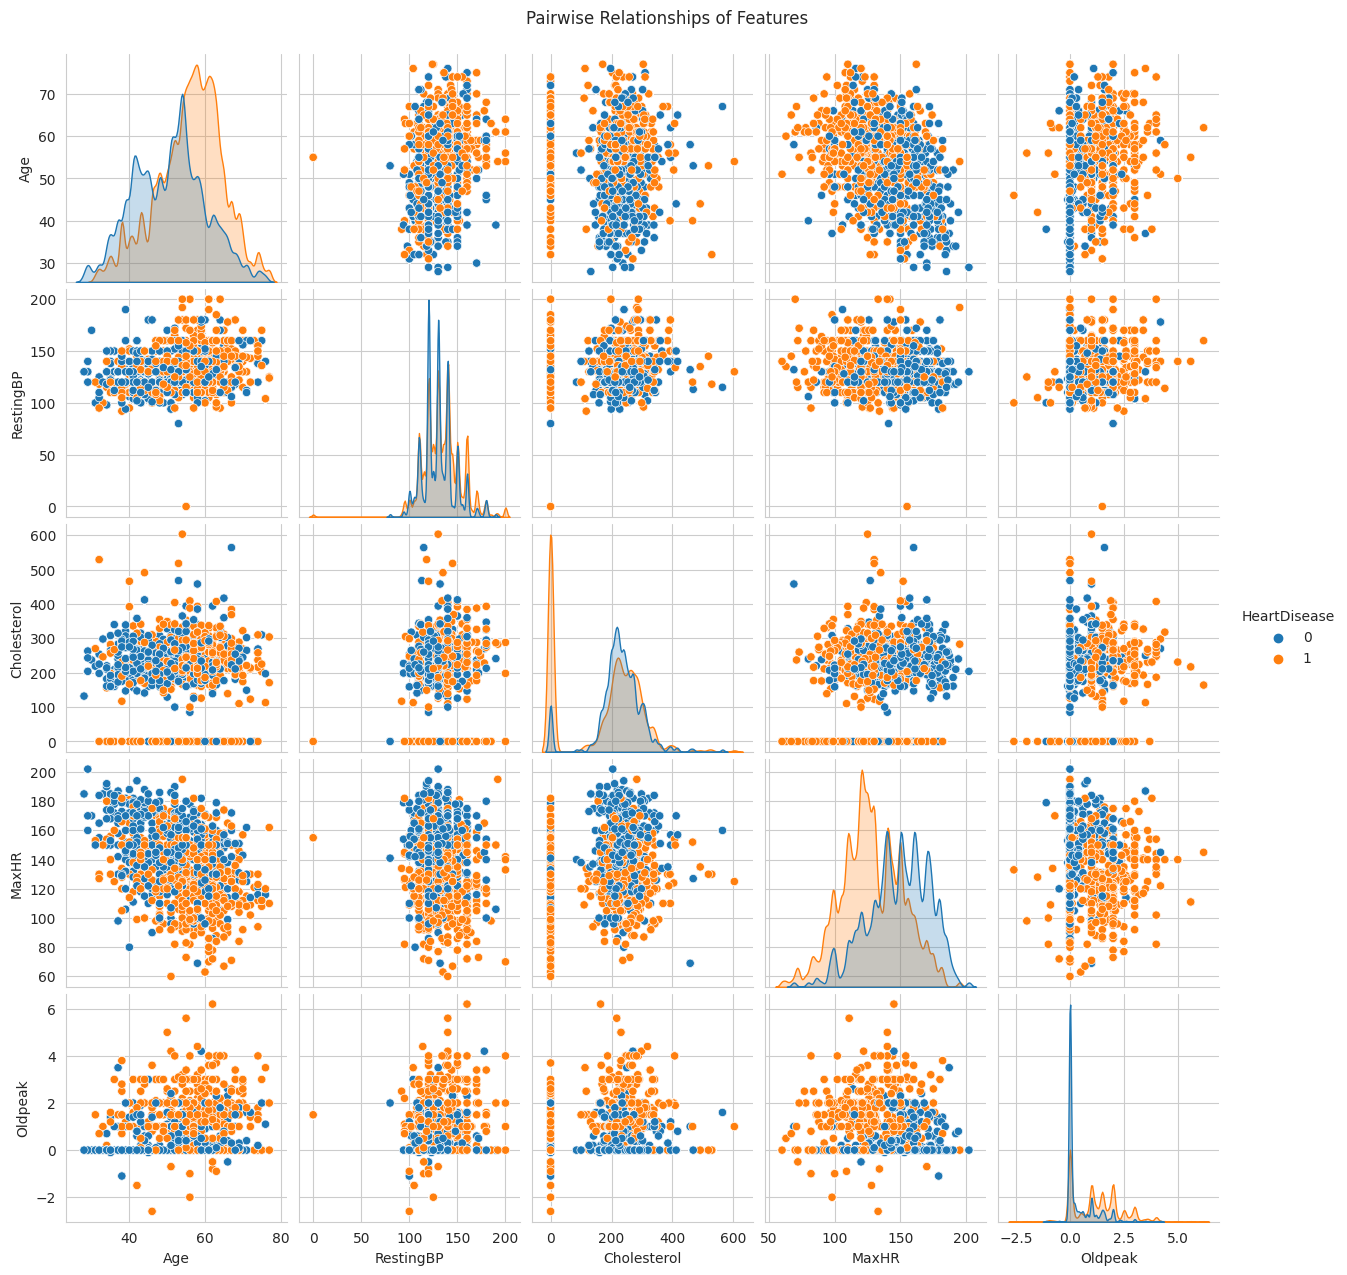

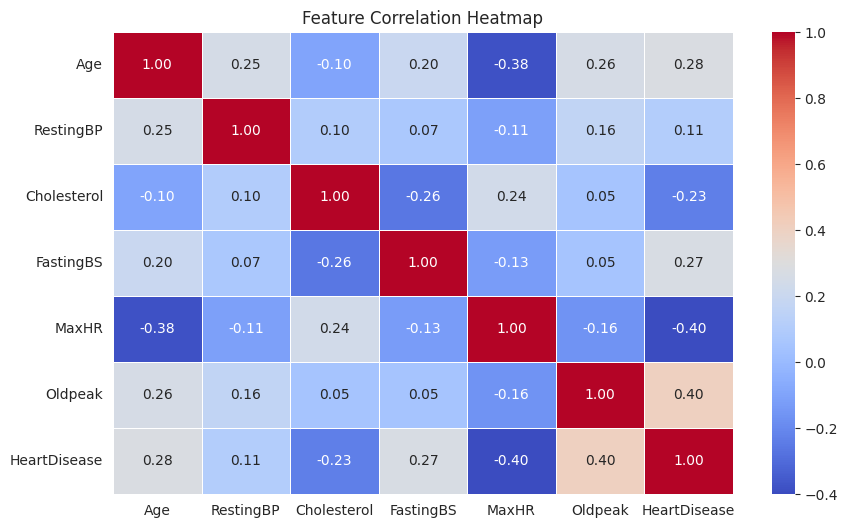

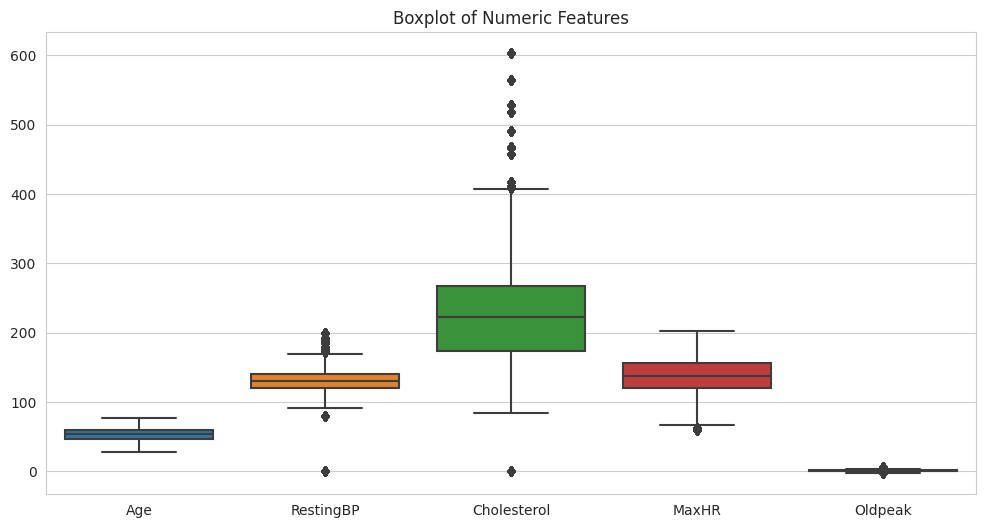

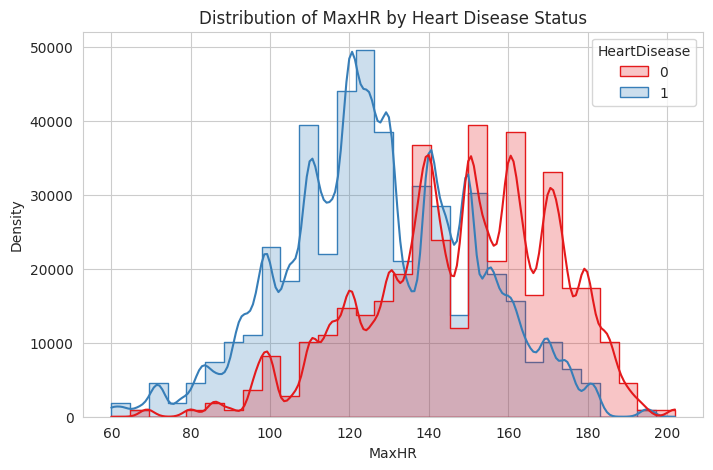

In [0]:
# Set seaborn style
sns.set_style("whitegrid")

# 1. Pairplot to visualize pairwise relationships
plt.figure(figsize=(10, 8))
sns.pairplot(heart_pd, diag_kind="kde", hue="HeartDisease", 
             vars=["Age", "RestingBP", "Cholesterol", "MaxHR", "Oldpeak"])
plt.suptitle("Pairwise Relationships of Features", y=1.02)
plt.show()

# 2. Correlation heatmap
plt.figure(figsize=(10, 6))
corr = heart_pd.corr()
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Feature Correlation Heatmap")
plt.show()

# 3. Boxplots for detecting outliers
plt.figure(figsize=(12, 6))
sns.boxplot(data=heart_pd[["Age", "RestingBP", "Cholesterol", "MaxHR", "Oldpeak"]])
plt.title("Boxplot of Numeric Features")
plt.show()

# 4. Distribution of MaxHR with respect to Heart Disease
plt.figure(figsize=(8, 5))
sns.histplot(data=heart_pd, x="MaxHR", hue="HeartDisease", kde=True, bins=30, element="step", palette="Set1")
plt.title("Distribution of MaxHR by Heart Disease Status")
plt.xlabel("MaxHR")
plt.ylabel("Density")
plt.show()

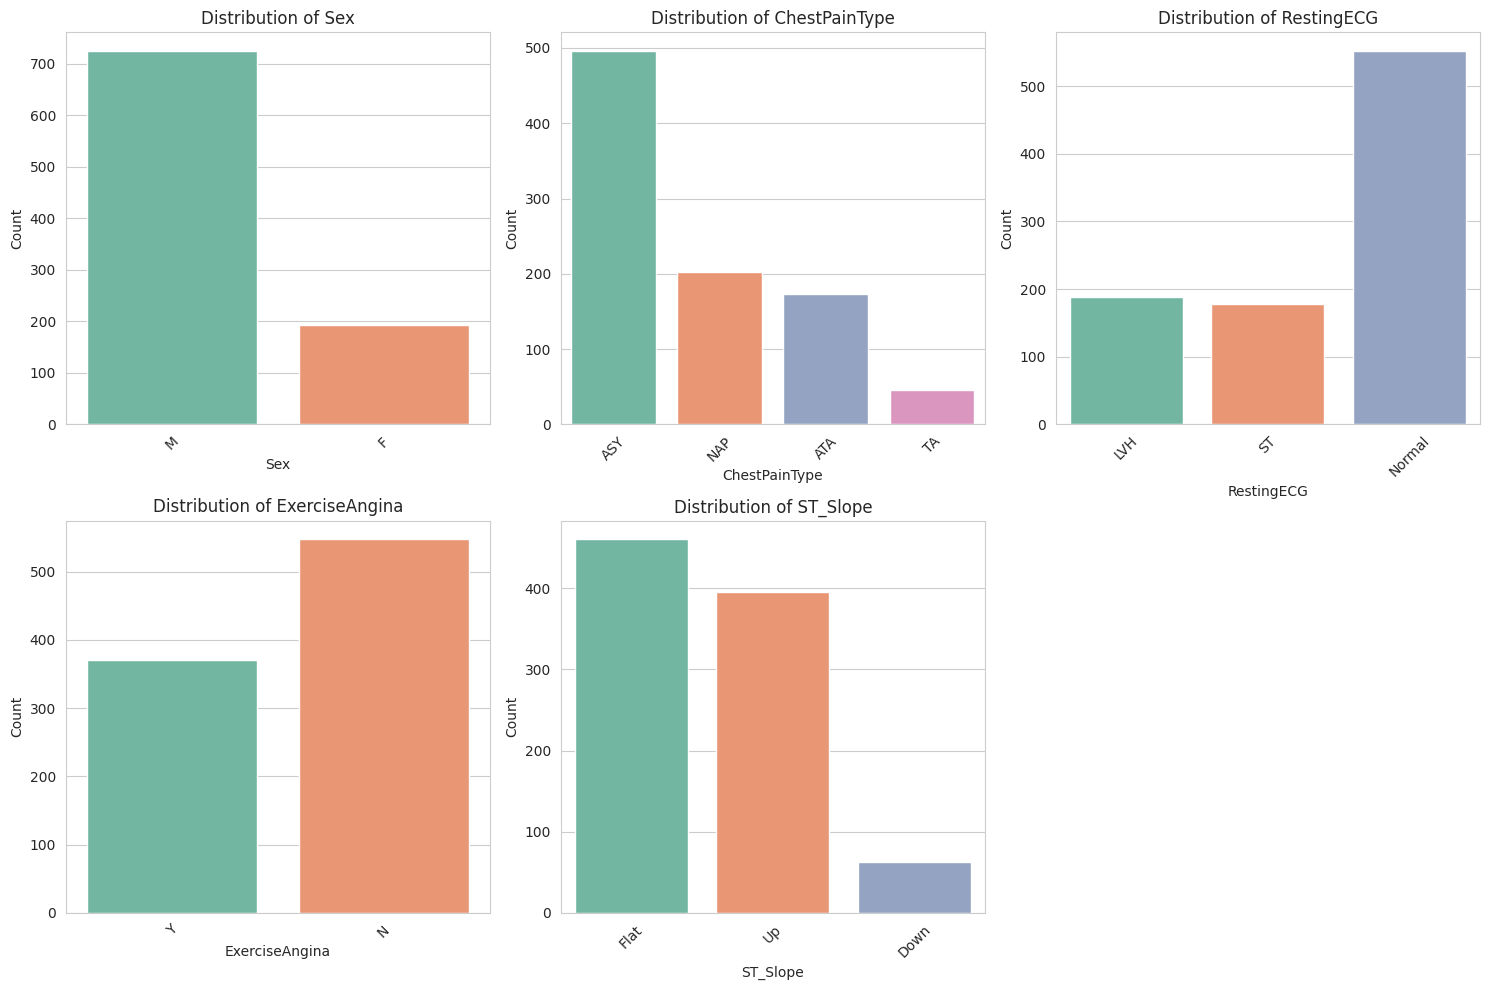

In [0]:
import matplotlib.pyplot as plt
import seaborn as sns
 
# Define categorical columns
categorical_columns = ["Sex", "ChestPainType", "RestingECG", "ExerciseAngina", "ST_Slope"]
 
# Set figure size
plt.figure(figsize=(15, 10))
 
# Loop through categorical columns and create subplots
for i, col in enumerate(categorical_columns, 1):
    plt.subplot(2, 3, i)  # Adjust layout (2 rows, 3 columns)
    sns.countplot(data=heart_df.toPandas(), x=col, palette="Set2")  # Convert Spark DataFrame to Pandas for plotting
    plt.title(f"Distribution of {col}")
    plt.xlabel(col)
    plt.ylabel("Count")
    plt.xticks(rotation=45)  # Rotate labels for better readability
 
# Adjust layout and show plot
plt.tight_layout()
plt.show()


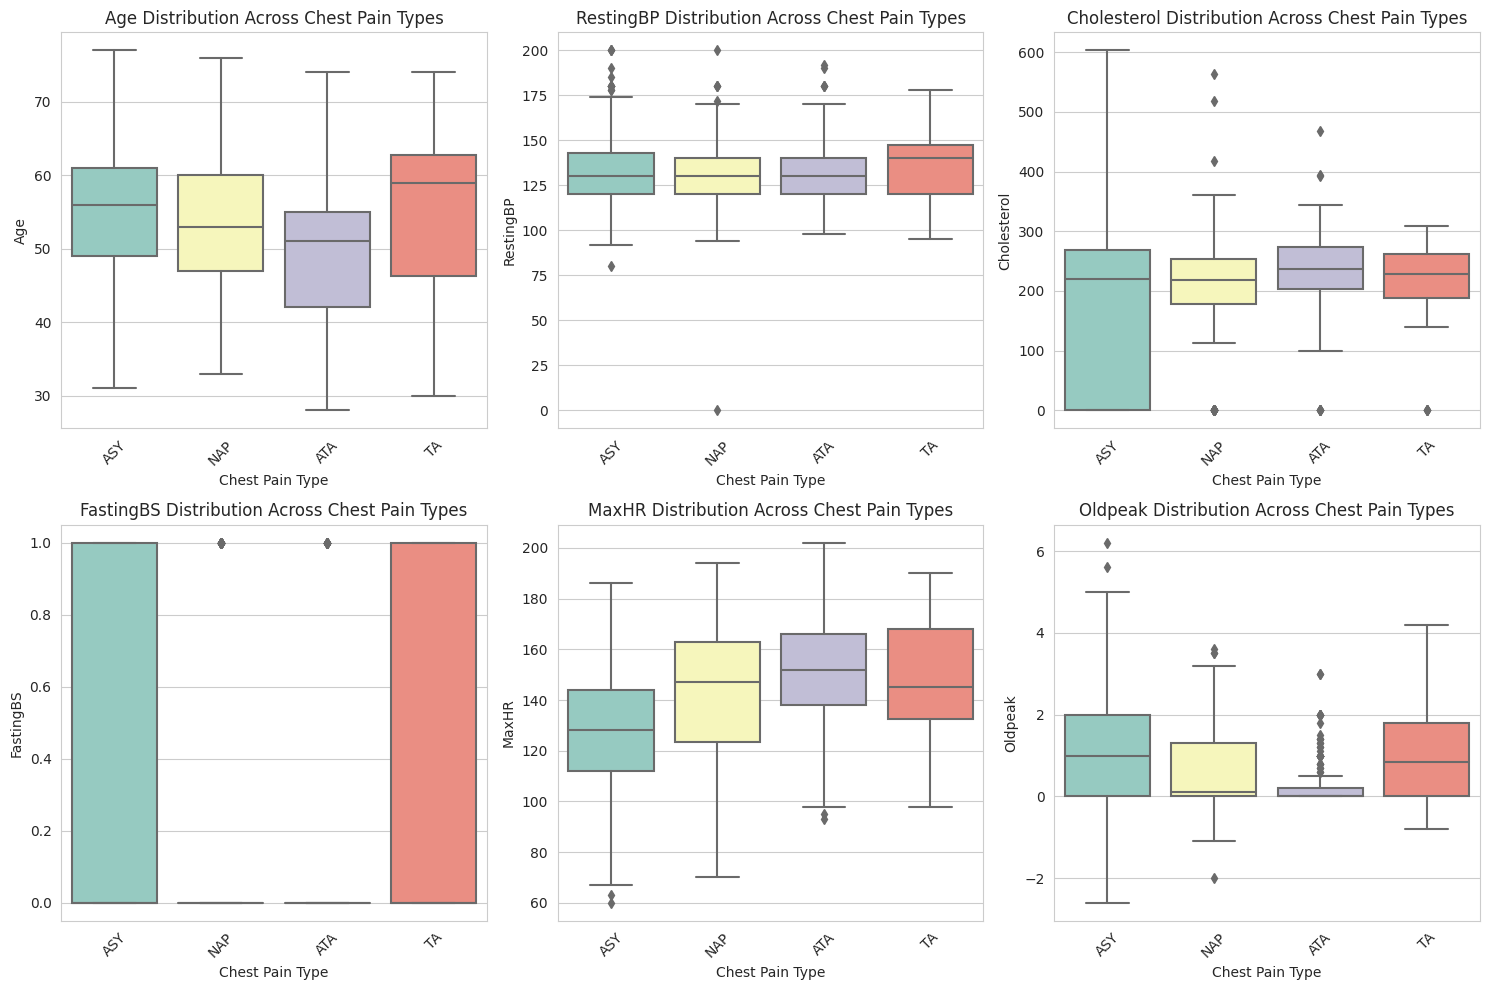

In [0]:
# Define categorical and numerical columns
categorical_columns = ["Sex", "ChestPainType", "RestingECG", "ExerciseAngina", "ST_Slope"]
numeric_columns = ["Age", "RestingBP", "Cholesterol", "FastingBS", "MaxHR", "Oldpeak"]
 
# Set figure size
plt.figure(figsize=(15, 10))
 
# Loop through numeric columns and create box plots
for i, col in enumerate(numeric_columns, 1):
    plt.subplot(2, 3, i)  # 2 rows, 3 columns
    sns.boxplot(data=heart_df.toPandas(), x="ChestPainType", y=col, palette="Set3")  # Example using 'ChestPainType'
    plt.title(f"{col} Distribution Across Chest Pain Types")
    plt.xlabel("Chest Pain Type")
    plt.ylabel(col)
    plt.xticks(rotation=45)
 
plt.tight_layout()
plt.show()

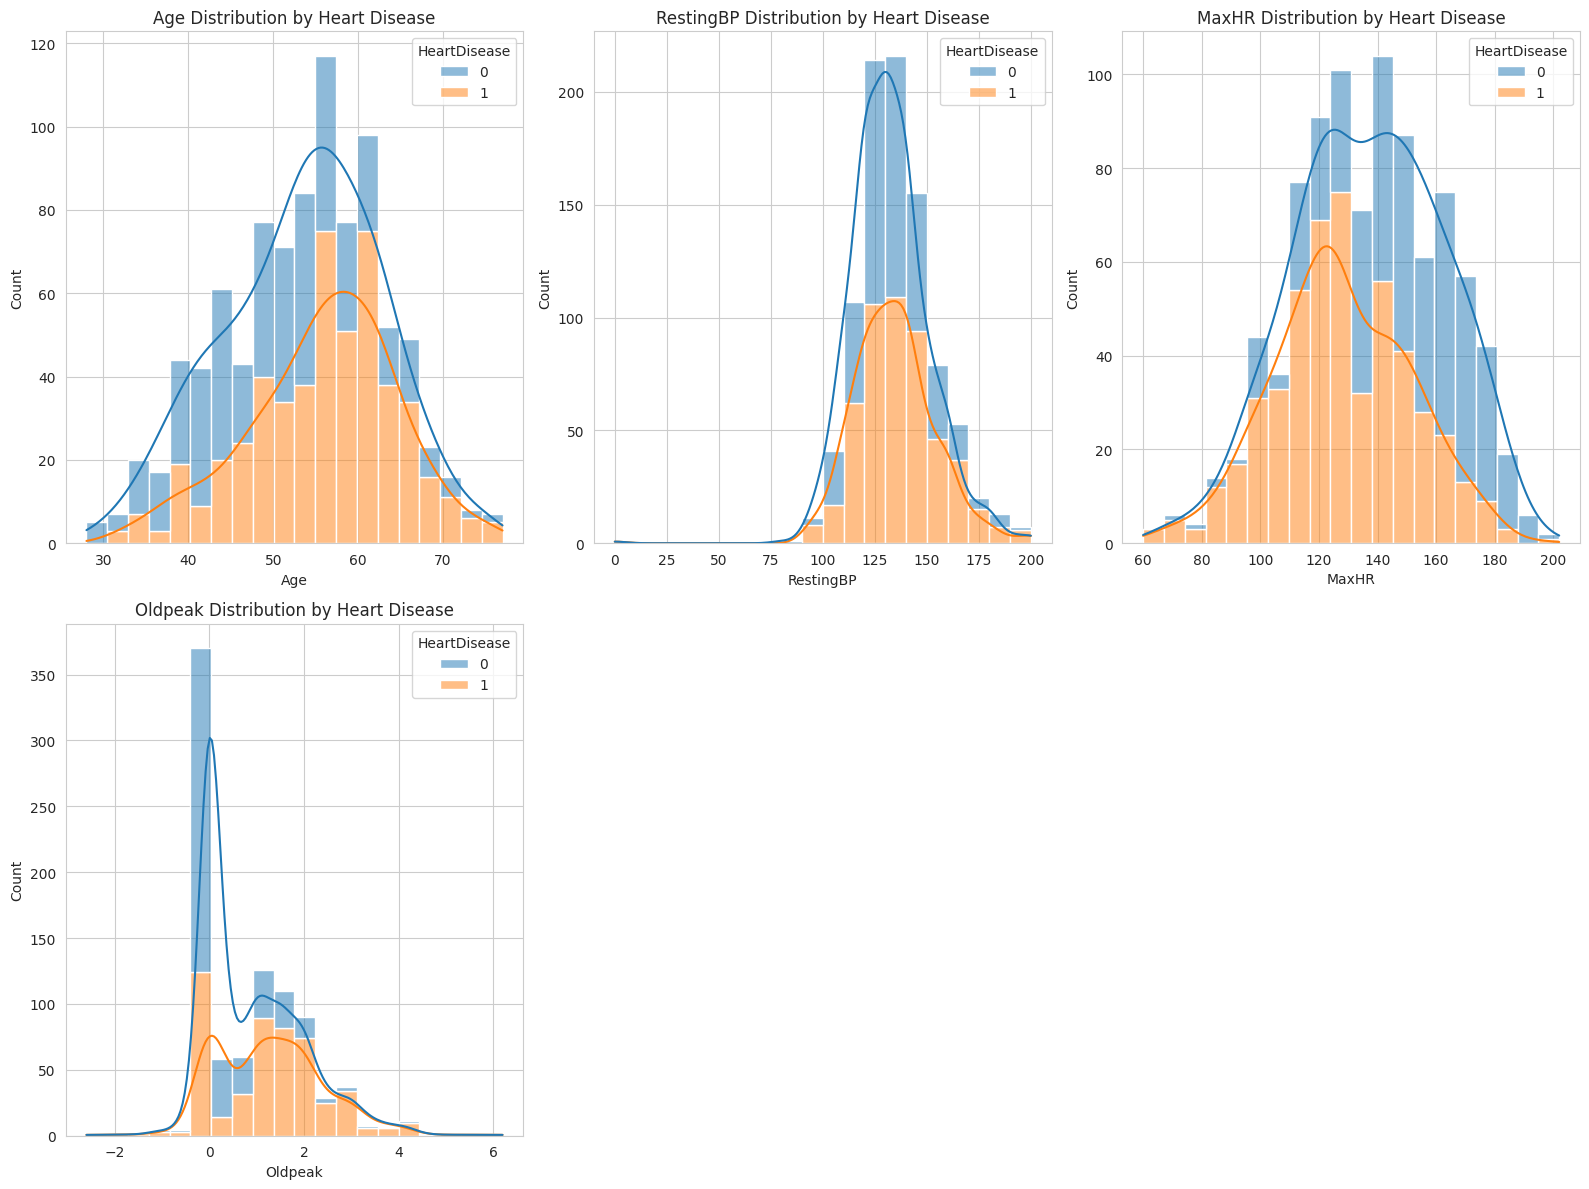

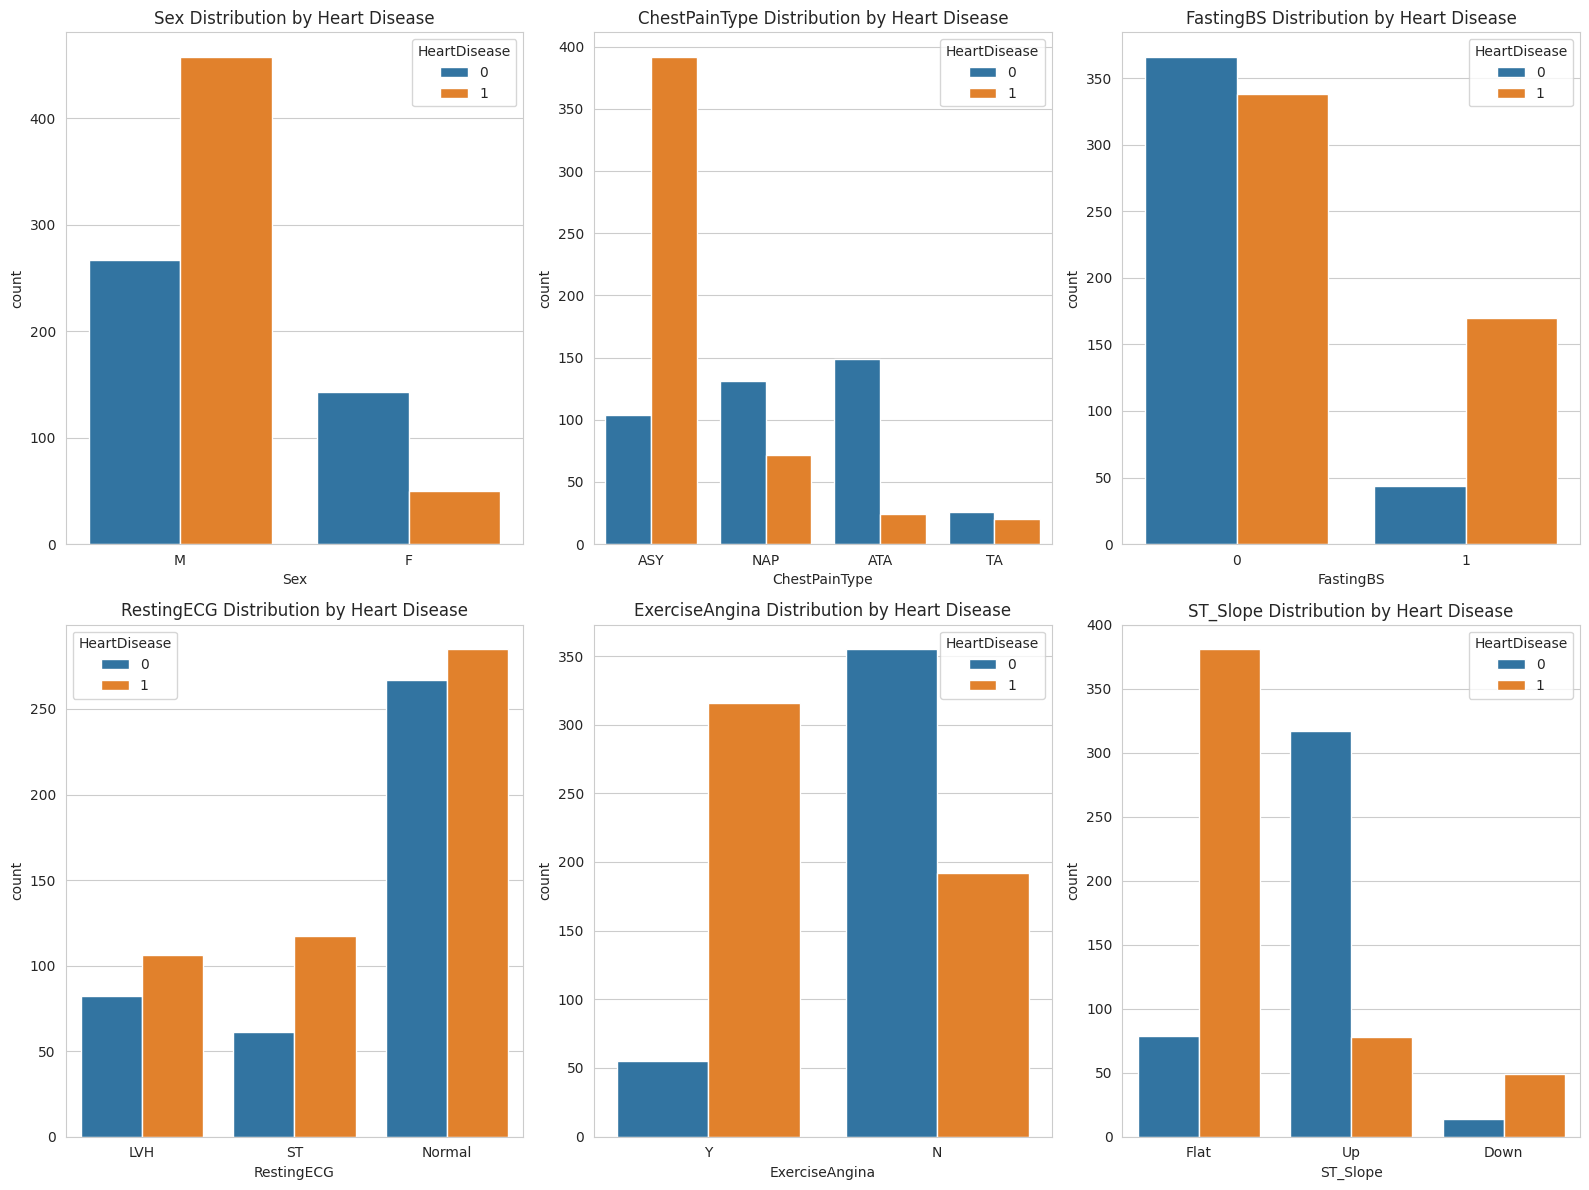

In [0]:
import matplotlib.pyplot as plt
import seaborn as sns
 
# Convert the PySpark DataFrame to a Pandas DataFrame for plotting
heart_df_pd = heart_df.toPandas()
 
# Set up the figure size
plt.figure(figsize=(16, 12))
 
# Plot distributions for continuous variables based on HeartDisease
features = ['Age', 'RestingBP',  'MaxHR', 'Oldpeak']  # List of continuous features
 
for i, feature in enumerate(features, 1):
    plt.subplot(2, 3, i)
    sns.histplot(data=heart_df_pd, x=feature, hue='HeartDisease', kde=True, bins=20, multiple="stack")
    plt.title(f'{feature} Distribution by Heart Disease')
 
plt.tight_layout()
plt.show()
 
# Plot for categorical features
categorical_features = ['Sex', 'ChestPainType', 'FastingBS', 'RestingECG', 'ExerciseAngina', 'ST_Slope']  # Categorical features
 
# Set up the figure size
plt.figure(figsize=(16, 12))
 
for i, feature in enumerate(categorical_features, 1):
    plt.subplot(2, 3, i)
    sns.countplot(x=feature, hue='HeartDisease', data=heart_df_pd)
    plt.title(f'{feature} Distribution by Heart Disease')
 
plt.tight_layout()
plt.show()

In [0]:
q1. import seaborn as sns
import matplotlib.pyplot as plt
 
# Plotting the distribution of age by gender and heart disease status
plt.figure(figsize=(10, 6))
sns.boxplot(data=heart_df.toPandas(), x='Sex', y='Age', hue='HeartDisease', palette='Set2')
plt.title('Age Distribution by Gender and Heart Disease Status')
plt.xlabel('Gender')
plt.ylabel('Age')
plt.show()
 
 
q2
plt.figure(figsize=(10, 6))
sns.countplot(data=heart_df.toPandas(), x='ChestPainType', hue='HeartDisease', palette='Set1')
plt.title('Chest Pain Type vs Heart Disease')
plt.xlabel('Chest Pain Type')
plt.ylabel('Count')
plt.show()
 
plt.figure(figsize=(10, 6))
sns.countplot(data=heart_df.toPandas(), x='ExerciseAngina', hue='HeartDisease', palette='Set1')
plt.title('Exercise Angina vs Heart Disease')
plt.xlabel('Exercise Angina')
plt.ylabel('Count')
plt.show()
 
 
q3
plt.figure(figsize=(10, 6))
sns.scatterplot(data=heart_df.toPandas(), x='RestingBP', y='MaxHR', hue='HeartDisease', palette='Set1')
plt.title('Resting Blood Pressure vs Maximum Heart Rate by Heart Disease Status')
plt.xlabel('Resting Blood Pressure')
plt.ylabel('Maximum Heart Rate')
plt.show()
 
 
q4
plt.figure(figsize=(10, 6))
sns.countplot(data=heart_df.toPandas(), x='RestingECG', hue='HeartDisease', palette='Set1')
plt.title('Resting ECG vs Heart Disease')
plt.xlabel('Resting ECG')
plt.ylabel('Count')
plt.show()
 
 
q5
plt.figure(figsize=(10, 6))
sns.countplot(data=heart_df.toPandas(), x='ST_Slope', hue='HeartDisease', palette='Set1')
plt.title('ST Slope vs Heart Disease')
plt.xlabel('ST Slope')
plt.ylabel('Count')
plt.show()
 
plt.figure(figsize=(10, 6))
sns.boxplot(data=heart_df.toPandas(), x='ST_Slope', y='Age', hue='HeartDisease', palette='Set2')
plt.title('Age Distribution by ST Slope and Heart Disease Status')
plt.xlabel('ST Slope')
plt.ylabel('Age')
plt.show()
 
 
q6
plt.figure(figsize=(10, 6))
sns.boxplot(data=heart_df.toPandas(), x='HeartDisease', y='Oldpeak', palette='Set2')
plt.title('Oldpeak Depression vs Heart Disease')
plt.xlabel('Heart Disease')
plt.ylabel('Oldpeak Depression')
plt.show()
 
plt.figure(figsize=(10, 6))
sns.violinplot(data=heart_df.toPandas(), x='HeartDisease', y='Oldpeak', hue='Sex', split=True, palette='Set2')
plt.title('Oldpeak Depression vs Heart Disease by Gender')
plt.xlabel('Heart Disease')
plt.ylabel('Oldpeak Depression')
plt.show()
 
 

  File <command-4230658403604325>, line 1
    q1. import seaborn as sns
        ^
SyntaxError: invalid syntax


In [0]:
pip install mlflow


In [0]:
dbutils.library.restartPython()

In [0]:
import mlflow
import mlflow.spark
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

# Set up MLflow experiment
mlflow.set_experiment('/Users/ctundwal@purdue.edu/heart_disease_experiment')

# Start an MLflow run
with mlflow.start_run():
    
    # Combine all features (numeric + encoded categorical features) into a single feature vector
    heart_df_enc = spark.read.parquet("dbfs:/mnt/heart_data/heart_cleaned.parquet")
    feature_columns = ["Age", "RestingBP", "Cholesterol", "FastingBS", "MaxHR", "Oldpeak"] + \
                      ["Sex_encoded", "ChestPainType_encoded", "RestingECG_encoded", "ExerciseAngina_encoded", "ST_Slope_encoded"]

    # Log feature names for reference
    mlflow.log_param("feature_columns", str(feature_columns))

    # VectorAssembler to combine all features into a single feature vector
    assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")

    # Transform the DataFrame to include the "features" column
    df_transformed = assembler.transform(heart_df_enc)

    # Split the data into training and testing sets
    train_data, test_data = df_transformed.randomSplit([0.8, 0.2], seed=1234)

    # Initialize the Random Forest Classifier model
    rf = RandomForestClassifier(labelCol="HeartDisease", featuresCol="features")

    # Define hyperparameter search space
    paramGrid = ParamGridBuilder() \
        .addGrid(rf.numTrees, [10, 50]) \
        .addGrid(rf.maxDepth, [5, 10]) \
        .addGrid(rf.impurity, ['gini']) \
        .build()

    # Define the evaluator
    evaluator = BinaryClassificationEvaluator(labelCol="HeartDisease", metricName="areaUnderROC")

    # Perform cross-validation (reduce folds for speed)
    cv = CrossValidator(estimator=rf, estimatorParamMaps=paramGrid, evaluator=evaluator, numFolds=2)

    # Fit the model using cross-validation
    cv_model = cv.fit(train_data)

    # Get the best model from cross-validation
    best_model = cv_model.bestModel

    # Make predictions on the test set
    predictions = best_model.transform(test_data)

    # Evaluate the model using AUC
    auc = evaluator.evaluate(predictions)

    # Log hyperparameters of the best model
    mlflow.log_param("best_numTrees", best_model.getNumTrees)
    mlflow.log_param("best_maxDepth", best_model.getOrDefault("maxDepth"))
    mlflow.log_param("best_impurity", best_model.getOrDefault("impurity"))

    # Log performance metrics
    mlflow.log_metric("AUC", auc)

    # Log the trained model
    mlflow.spark.log_model(best_model, "best_random_forest_model")

    print(f"Best Model AUC: {auc}")
